In [4]:
%pip install numpy pandas matplotlib scikit-learn h5py

You should consider upgrading via the 'c:\Users\yongz\Documents\ICT2211\Nature energy - code\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [34]:
import h5py
import scipy.io
import scipy.stats
import sklearn.metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
matFilename = './Data/2017-05-12_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(matFilename)

In [4]:
batch = f['batch']
list(batch.keys())

['Vdlin',
 'barcode',
 'channel_id',
 'cycle_life',
 'cycles',
 'policy',
 'policy_readable',
 'summary']

In [5]:
summary = f[batch['summary'][0,0]]
summary.keys()

<KeysViewHDF5 ['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle']>

In [6]:
num_cells = batch['summary'].shape[0]
num_cells

46

## Features

In [7]:
bat_info = pd.DataFrame(
    [
        [str(row), str(row), '???', '???', int(f[batch['cycle_life'][row,0]][0,0])]
        for row in range(num_cells)
    ],
    columns=('battery_id','channel_id','policy','policy_readable','cycle_life'))
feat = np.zeros([num_cells,13], dtype=np.float32)
for i in range(num_cells):
    summary = f[batch['summary'][i,0]]
    # capacity features
    feat[i,0] = summary['QDischarge'][0,1]
    feat[i,1] = max(
        summary['QDischarge'][0,0:99]
    ) - feat[i,0]
    # quoted: "fix data issue"
    feat[1,1] = 0.0064
    feat[i,2] = summary['QDischarge'][0,99]

    # Q features
    cycles = f[batch['cycles'][i,0]]

    Q10 = np.hstack((f[cycles['Qdlin'][9,0]]))
    Q100 = np.hstack((f[cycles['Qdlin'][99,0]]))
    Qdiff = Q100 - Q10

    feat[i,3] = np.log10(np.abs(np.min(Qdiff)))
    feat[i,4] = np.log10(np.abs(np.mean(Qdiff)))
    feat[i,5] = np.log10(np.abs(np.var(Qdiff)))
    feat[i,6] = np.log10(np.abs(scipy.stats.skew(Qdiff)))
    feat[i,7] = np.log10(np.abs(scipy.stats.kurtosis(Qdiff)))
    feat[i,8] = np.log10(np.abs(Qdiff[0]))

    # https://stackoverflow.com/questions/46779605/in-the-linearregression-method-in-sklearn-what-exactly-is-the-fit-intercept-par
    R3 = linear_model.LinearRegression(fit_intercept=True)
    R3.fit(
        np.arange(2,100).reshape(-1,1),
        summary['QDischarge'][0,1:99]
    )
    feat[i,9] = R3.coef_[0]
    feat[i,10] = R3.intercept_

    R1 = linear_model.LinearRegression(fit_intercept=True)
    R1.fit(
        np.arange(91,100).reshape(-1,1),
        summary['QDischarge'][0,90:99]
    )
    feat[i,11] = R1.coef_[0]
    feat[i,12] = R1.intercept_


In [8]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

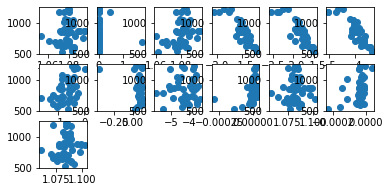

In [21]:
for i in range(feat.shape[1]):
    plt.subplot(4, 6, i+1)
    plt.scatter(feat[:,i], bat_info["cycle_life"])

plt.show()

## Model Building

In [26]:
# randomly partition into train and test
feat_train, feat_test, label_train, label_test = train_test_split(
    feat, bat_info["cycle_life"],
    test_size=0.5
    # the paper split every other cell, resulting in 50-50 mix
)

In [31]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

In [32]:
# train model
# Linear Elastic Net with Four-Fold Cross-Validation, alpha = 0.9
B = linear_model.ElasticNetCV(cv=4, l1_ratio=0.9)
B.fit(feat_train_scaled, label_train)

ElasticNetCV(cv=4, l1_ratio=0.9)

In [33]:
# make predictions
ypred_train = B.predict(feat_train_scaled)
ypred_test = B.predict(feat_test_scaled)

## Evaluation

In [39]:
# calculate prediction interval (incomplete)
print(sklearn.metrics.mean_squared_error(label_train, ypred_train))
print(sklearn.metrics.mean_squared_error(label_test, ypred_test))

5410.803601584033
9957.92911262875
